### Import Library & Data

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import lightgbm
import xgboost as xgb

from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, classification_report
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE

pd.set_option('display.max_columns', None)

In [20]:
df = pd.read_csv('for_modelling_task.csv')
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,STATUS_ACTIVE,STATUS_CLOSED,STATUS_BAD_DEBT,TOTAL_CREDITS,RATIO_BAD_TO_TOTAL,CREDIT_GROUP_RETAIL,CREDIT_GROUP_ASSET,CREDIT_GROUP_BUSINESS,RATIO_ASSET_TO_TOTAL,AMT_CREDIT_SUM_MEAN,AMT_CREDIT_SUM_DEBT_MEAN,RATIO_DEBT_TO_CREDIT_MEAN,DAYS_CREDIT_MEAN,DAYS_CREDIT_ENDDATE_MEAN,PREV_APP_COUNT,PREV_AMT_APPLICATION_MEAN,PREV_AMT_CREDIT_MEAN,PREV_AMT_ANNUITY_MEAN,PREV_AMT_GOODS_PRICE_MEAN,PREV_DAYS_DECISION_MEAN,PREV_CNT_PAYMENT_MEAN,PREV_POS_RATIO_ACTIVE_MEAN,PREV_POS_RATIO_COMPLETED_MEAN,PREV_POS_RATIO_PROBLEMATIC_MEAN,PREV_CC_UTILIZATION_MEAN,PREV_CC_AVG_DPD_DEF_MEAN,PREV_INST_PAYMENT_RATIO_MEAN,PREV_INST_LATE_PAYMENT_RATIO_MEAN,PREV_INST_MISSED_PAYMENT_RATE_MEAN,PREV_CONTRACT_STATUS_APPROVED_RATIO,PREV_CONTRACT_STATUS_REFUSED_RATIO,PREV_CONTRACT_STATUS_CANCELED_RATIO,PREV_CONTRACT_STATUS_UNUSED_OFFER_RATIO,PREV_CONTRACT_STATUS_UNKNOWN_RATIO,PREV_CONTRACT_TYPE_CASH_LOANS_RATIO,PREV_CONTRACT_TYPE_CONSUMER_LOANS_RATIO,PREV_CONTRACT_TYPE_REVOLVING_LOANS_RATIO,PREV_CONTRACT_TYPE_UNKNOWN_RATIO,PREV_PORTFOLIO_CASH_RATIO,PREV_PORTFOLIO_CARDS_RATIO,PREV_PORTFOLIO_POS_RATIO,PREV_PORTFOLIO_CARS_RATIO,PREV_PORTFOLIO_UNKNOWN_RATIO,PREV_CLIENT_TYPE_NEW_RATIO,PREV_CLIENT_TYPE_REPEATER_RATIO,PREV_CLIENT_TYPE_REFRESHED_RATIO,PREV_CLIENT_TYPE_UNKNOWN_RATIO,PREV_PRODUCT_TYPE_WALKIN_RATIO,PREV_PRODUCT_TYPE_XSELL_RATIO,PREV_PRODUCT_TYPE_UNKNOWN_RATIO,PREV_REJECT_XAP_RATIO,PREV_REJECT_XNA_RATIO,PREV_REJECT_HC_RATIO,PREV_REJECT_LIMIT_RATIO,PREV_REJECT_SCO_RATIO,PREV_REJECT_SCOFR_RATIO,PREV_REJECT_SYSTEM_RATIO,PREV_REJECT_VERIF_RATIO,PREV_REJECT_UNKNOWN_RATIO,NAME_TYPE_SUITE_GROUP,NAME_INCOME_TYPE_GROUP,ORGANIZATION_TYPE_GROUP,AGE_YEARS,AGE_YEARS_BINNED,YEARS_EMPLOYED,CNT_CHILDREN_BINNED,CNT_FAM_MEMBERS_BINNED,FLAG_OWN_CAR_MAP,FLAG_OWN_REALTY_MAP,DTI,PAYMENT_RATIO,DTI_BINNING,PAYMENT_RATIO_BINNING,LTV,LTV_BINNING,HAS_ACTIVE_CREDIT_EXT,HAS_BAD_DEBT_EXT,PREV_CLIENT_TYPE_REFRESHED_BINNED,PREV_CLIENT_TYPE_REPEATER_BINNED,INST_LATE_PAYMENT_RATIO_BINNED,PREV_REJECT_HC_RATIO_Binned,PREV_REJECT_LIMIT_RATIO_Binned,PREV_REJECT_SCO_RATIO_Binned,PREV_REJECT_SCOFR_RATIO_Binned,PREV_REJECT_SYSTEM_RATIO_Binned,PREV_REJECT_VERIF_RATIO_Binned,PREV_REJECT_XAP_RATIO_Binned,PREV_REJECT_XNA_RATIO_Binned,PREV_CONTRACT_STATUS_REFUSED_BINNED,PREV_PORTFOLIO_POS_RATIO_Binned,PREV_PORTFOLIO_CASH_RATIO_Binned,PREV_PORTFOLIO_CARS_RATIO_Binned,PREV_PRODUCT_TYPE_XSELL_RATIO_Binned,PREV_PRODUCT_TYPE_WALKIN_RATIO_Binned,ASSET_STATUS
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637.0,-3648.0,-2120,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNE

In [21]:
df.shape

(307511, 169)

In [22]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 169 columns):
 #    Column                                    Dtype  
---   ------                                    -----  
 0    SK_ID_CURR                                int64  
 1    TARGET                                    int64  
 2    NAME_CONTRACT_TYPE                        object 
 3    CODE_GENDER                               object 
 4    FLAG_OWN_CAR                              object 
 5    FLAG_OWN_REALTY                           object 
 6    CNT_CHILDREN                              int64  
 7    AMT_INCOME_TOTAL                          float64
 8    AMT_CREDIT                                float64
 9    AMT_ANNUITY                               float64
 10   AMT_GOODS_PRICE                           float64
 11   NAME_TYPE_SUITE                           object 
 12   NAME_INCOME_TYPE                          object 
 13   NAME_EDUCATION_TYPE                       

### Pengecekan kembali kemungkinan adanya Noise

In [23]:
print(f'Jumlah data yang terduplikat adalah: {df.duplicated().sum()}')

Jumlah data yang terduplikat adalah: 0


In [24]:
pd.set_option('display.max_rows', None)
print("Jumlah missing values per kolom:")
print(df.isna().sum())

Jumlah missing values per kolom:
SK_ID_CURR                                      0
TARGET                                          0
NAME_CONTRACT_TYPE                              0
CODE_GENDER                                     0
FLAG_OWN_CAR                                    0
FLAG_OWN_REALTY                                 0
CNT_CHILDREN                                    0
AMT_INCOME_TOTAL                                0
AMT_CREDIT                                      0
AMT_ANNUITY                                     0
AMT_GOODS_PRICE                                 0
NAME_TYPE_SUITE                                 0
NAME_INCOME_TYPE                                0
NAME_EDUCATION_TYPE                             0
NAME_FAMILY_STATUS                              0
NAME_HOUSING_TYPE                               0
REGION_POPULATION_RELATIVE                      0
DAYS_BIRTH                                      0
DAYS_EMPLOYED                               55374
DAYS_REGISTRATION

- Pada pengecekan missing value terlihat bahwa kolom 'DAYS_EMPLOYED' memiliki missing value dikarenakan pada bagian sebelumnya, nilai DAYS_EMPLOYED yang terdefinisikan 365243 diubah nilainya menjadi NaN. Efeknya pada pembuatan kolom baru 'YEARS_EMPLOYED' mendapatkan hal yang sama.

- Untuk kolom 'LTV_BINNING', kolomnya akan dihapus saja dikarenakan data utamanya 'LTV'.

Pengecekan outlier

In [25]:
def iqr_outlier(df, features):
    outlier_report = []

    for col in features:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outlier_count = df[(df[col] < lower_bound) | (df[col] > upper_bound)].shape[0]
        pct_outliers = (outlier_count / len(df)) * 100

        if outlier_count > 0 :
            outlier_report.append({
                'Feature': col,
                'Outlier Count': outlier_count,
                'Percentage of Outliers': pct_outliers,
                'Min_Value': df[col].min(),
                'Max_Value': df[col].max(),
                'Upper Bound': upper_bound
            })

    report_df = pd.DataFrame(outlier_report)
    return report_df

In [26]:
num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
num_cols = [col for col in num_cols if df[col].nunique() > 2]

outlier_summary = iqr_outlier(df, num_cols)
print("Outlier Summary:")
print(outlier_summary.head(20).sort_values(by='Percentage of Outliers', ascending=False))

Outlier Summary:
                        Feature  Outlier Count  Percentage of Outliers  \
12                 EXT_SOURCE_1         134131               43.618277   
9          REGION_RATING_CLIENT          80527               26.186706   
10  REGION_RATING_CLIENT_W_CITY          78027               25.373726   
15     DEF_30_CNT_SOCIAL_CIRCLE          35166               11.435688   
17     DEF_60_CNT_SOCIAL_CIRCLE          25769                8.379863   
14     OBS_30_CNT_SOCIAL_CIRCLE          19971                6.494402   
16     OBS_60_CNT_SOCIAL_CIRCLE          19564                6.362049   
6                 DAYS_EMPLOYED          15149                4.926328   
4               AMT_GOODS_PRICE          14728                4.789422   
1              AMT_INCOME_TOTAL          14035                4.564064   
5    REGION_POPULATION_RELATIVE           8412                2.735512   
3                   AMT_ANNUITY           7504                2.440238   
2                    

Pengecekan fitur-fitur kategorikal

In [27]:
for col in df.select_dtypes(include=['object']).columns:
    print(f"Kolom: {col}")
    print(df[col].value_counts())
    print("\n")

Kolom: NAME_CONTRACT_TYPE
NAME_CONTRACT_TYPE
Cash loans         278232
Revolving loans     29279
Name: count, dtype: int64


Kolom: CODE_GENDER
CODE_GENDER
F      202448
M      105059
XNA         4
Name: count, dtype: int64


Kolom: FLAG_OWN_CAR
FLAG_OWN_CAR
N    202924
Y    104587
Name: count, dtype: int64


Kolom: FLAG_OWN_REALTY
FLAG_OWN_REALTY
Y    213312
N     94199
Name: count, dtype: int64


Kolom: NAME_TYPE_SUITE
NAME_TYPE_SUITE
Unaccompanied      248526
Family              40149
Spouse, partner     11370
Children             3267
Other_B              1770
Unknown              1292
Other_A               866
Group of people       271
Name: count, dtype: int64


Kolom: NAME_INCOME_TYPE
NAME_INCOME_TYPE
Working                 158774
Commercial associate     71617
Pensioner                55362
State servant            21703
Unemployed                  22
Student                     18
Businessman                 10
Maternity leave              5
Name: count, dtype: int64


Kolom:

### Penanganan Noise pada Dataset

Penanganan missing value

In [28]:
# Sentinel handling & derived features (aligned with HC-AnalysisData.ipynb)
if 'DAYS_EMPLOYED' in df.columns:
    df['DAYS_EMPLOYED'] = df['DAYS_EMPLOYED'].replace(365243, np.nan)

# Derive YEARS_EMPLOYED if not available (days are negative in raw Home Credit data)
if 'YEARS_EMPLOYED' not in df.columns and 'DAYS_EMPLOYED' in df.columns:
    df['YEARS_EMPLOYED'] = (-df['DAYS_EMPLOYED'] / 365).clip(lower=0)

# Fill missing employment duration as 0 (interpreted as not working / unknown)
if 'YEARS_EMPLOYED' in df.columns:
    df['YEARS_EMPLOYED'] = df['YEARS_EMPLOYED'].fillna(0)

# Derive AGE_YEARS if not available
if 'AGE_YEARS' not in df.columns and 'DAYS_BIRTH' in df.columns:
    df['AGE_YEARS'] = (-df['DAYS_BIRTH'] / 365).astype(int)

In [29]:
# Missing value handling (aligned with HC-AnalysisData.ipynb)
cat_features = [c for c in ['OCCUPATION_TYPE', 'NAME_TYPE_SUITE'] if c in df.columns]
if cat_features:
    df[cat_features] = df[cat_features].fillna('Unknown')

num_features_median = [
    c for c in [
        'AMT_GOODS_PRICE', 'AMT_ANNUITY', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
        'CNT_FAM_MEMBERS', 'DAYS_LAST_PHONE_CHANGE'
    ]
    if c in df.columns
 ]
for col in num_features_median:
    df[col] = df[col].fillna(df[col].median())

social_features = [
    c for c in [
        'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
        'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE'
    ]
    if c in df.columns
 ]
for col in social_features:
    df[col] = df[col].fillna(df[col].median())

def _fillna_existing(cols, value):
    existing = [c for c in cols if c in df.columns]
    if existing:
        df[existing] = df[existing].fillna(value)

explicit_zero_cols = [
    'AMT_REQ_CREDIT_BUREAU_HOUR',
    'AMT_REQ_CREDIT_BUREAU_DAY',
    'AMT_REQ_CREDIT_BUREAU_WEEK',
    'AMT_REQ_CREDIT_BUREAU_MON',
    'AMT_REQ_CREDIT_BUREAU_QRT',
    'AMT_REQ_CREDIT_BUREAU_YEAR',
    'STATUS_ACTIVE',
    'STATUS_CLOSED',
    'STATUS_BAD_DEBT',
    'TOTAL_CREDITS',
    'RATIO_BAD_TO_TOTAL',
    'CREDIT_GROUP_RETAIL',
    'CREDIT_GROUP_ASSET',
    'CREDIT_GROUP_BUSINESS',
    'RATIO_ASSET_TO_TOTAL',
    'CC_RATIO_ACTIVE',
    'CC_RATIO_COMPLETED',
    'CC_RATIO_PROBLEMATIC',
    'POS_RATIO_ACTIVE',
    'POS_RATIO_COMPLETED',
    'POS_RATIO_PROBLEMATIC',
    'PREV_APP_COUNT',
    'PREV_CONTRACT_STATUS_REFUSED_RATIO',
    'PREV_APPROVED_RATIO',
    'PREV_CANCELED_RATIO',
    'PREV_REFUSED_RATIO',
    'PREV_UNUSED_OFFER_RATIO',
    'PREV_REJECT_HC_RATIO',
    'PREV_REJECT_LIMIT_RATIO',
    'PREV_REJECT_SCO_RATIO',
    'PREV_REJECT_SCOFR_RATIO',
    'PREV_REJECT_SYSTEM_RATIO',
    'PREV_REJECT_VERIF_RATIO',
    'PREV_REJECT_UNKNOWN_RATIO',
 ]

prev_ratio_features = [c for c in df.columns if c.startswith('PREV_') and c.endswith('_RATIO')]
prev_mean_features = [c for c in df.columns if c.startswith('PREV_') and c.endswith('_MEAN')]
prev_count_features = [c for c in ['PREV_APP_COUNT'] if c in df.columns]

zero_fill_cols = sorted(set(explicit_zero_cols + prev_ratio_features + prev_mean_features + prev_count_features))
_fillna_existing(zero_fill_cols, 0)

In [30]:
df['YEARS_EMPLOYED'].value_counts()

YEARS_EMPLOYED
0.000000     55376
0.547945       156
0.613699       152
0.630137       151
0.545205       151
0.580822       150
1.052055       143
0.627397       143
0.632877       140
0.589041       138
0.567123       138
0.591781       137
0.515068       137
0.536986       136
0.317808       136
0.608219       135
0.528767       134
0.534247       133
0.586301       132
0.695890       131
0.583562       131
0.550685       130
1.043836       130
0.638356       128
0.506849       128
0.531507       127
0.649315       127
0.504110       126
0.641096       126
0.572603       125
0.953425       125
0.660274       124
2.041096       123
0.375342       123
1.046575       122
0.380822       122
0.542466       122
0.652055       122
0.597260       120
0.657534       120
0.561644       120
0.523288       120
0.323288       119
0.610959       119
0.616438       119
0.495890       118
1.178082       118
0.668493       118
0.621918       118
0.734247       117
1.013699       117
0.364384       1

In [31]:
df.drop(columns=['LTV_BINNING'], inplace=True)

- Dalam tahapan berikutnya akan dilakukan proses binning terhadap YEARS_EMPLOYED dikarenakan datanya cukup beragam sehingga harus dikelompokkan agar lebih ringkas

In [32]:
df.select_dtypes(include=['object']).columns

Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
       'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE',
       'NAME_TYPE_SUITE_GROUP', 'NAME_INCOME_TYPE_GROUP',
       'ORGANIZATION_TYPE_GROUP', 'AGE_YEARS_BINNED', 'CNT_CHILDREN_BINNED',
       'CNT_FAM_MEMBERS_BINNED', 'FLAG_OWN_CAR_MAP', 'FLAG_OWN_REALTY_MAP',
       'DTI_BINNING', 'PAYMENT_RATIO_BINNING',
       'PREV_CLIENT_TYPE_REFRESHED_BINNED', 'PREV_CLIENT_TYPE_REPEATER_BINNED',
       'INST_LATE_PAYMENT_RATIO_BINNED', 'PREV_REJECT_HC_RATIO_Binned',
       'PREV_REJECT_LIMIT_RATIO_Binned', 'PREV_REJECT_SCO_RATIO_Binned',
       'PREV_REJECT_SCOFR_RATIO_Binned', 'PREV_REJECT_SYSTEM_RATIO_Binned',
       'PREV_REJECT_VERIF_RATIO_Binned', 'PREV_REJECT_XAP_RATIO_Binned',
       'PREV_REJECT_XNA_RATIO_Binned', 'PREV_CONTRACT_STATUS_REFUSED_BINNED',
       'PREV_PO

Penanganan outlier

In [33]:
def cap_outliers(df, cols, upper_quantile=0.99):
    df_clean = df.copy()
    for col in cols:
        upper_limit = df_clean[col].quantile(upper_quantile)
        df_clean[col] = np.where(df_clean[col] > upper_limit, upper_limit, df_clean[col])

    return df_clean

In [34]:
cols_to_cap = [
    'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
    'CNT_CHILDREN', 'CNT_FAM_MEMBERS',
    'AMT_REQ_CREDIT_BUREAU_QRT',
    'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
    'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE',
 ]

cols_to_cap = [c for c in cols_to_cap if c in df.columns]

In [35]:
print(f'Contoh nilai maksimum Income sebelum penanganan outlier: {df["AMT_INCOME_TOTAL"].max()}')
df = cap_outliers(df, cols_to_cap, upper_quantile=0.99)
print(f'Contoh nilai maksimum Income setelah penanganan outlier: {df["AMT_INCOME_TOTAL"].max()}')

Contoh nilai maksimum Income sebelum penanganan outlier: 117000000.0
Contoh nilai maksimum Income setelah penanganan outlier: 472500.0


- Kolom-kolom tertentu harus diterapkan metode capping agar membatasi skala tidak terlalu jauh (nilai minimum & nilai maksimum)
- Kolom-kolom tertentu juga tidak ada penanganan outlier karena menggambarkan nilai tertentu, bukan angka acak (seperti kolom sumber eksternal, dll.)

Penanganan awal data kategorikal

In [36]:
cols_categoical_to_drop = [
    'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'ORGANIZATION_TYPE',
    'AGE_YEARS_BINNED', 'CNT_CHILDREN_BINNED', 'CNT_FAM_MEMBERS_BINNED',
    'DTI_BINNING', 'PAYMENT_RATIO_BINNING', 'LTV_BINNING',
    'FLAG_OWN_CAR_MAP', 'FLAG_OWN_REALTY_MAP', 'ASSET_STATUS'
]

binned_cols = [col for col in df.columns if '_Binned' in col or '_BINNED' in col]
cols_categoical_to_drop.extend(binned_cols)

In [37]:
df_clean = df.drop(columns=cols_categoical_to_drop, errors='ignore')

In [38]:
df_clean['CODE_GENDER'] = df_clean['CODE_GENDER'].replace('XNA', 'F')

In [39]:
df_clean.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 140 columns):
 #    Column                                    Dtype  
---   ------                                    -----  
 0    SK_ID_CURR                                int64  
 1    TARGET                                    int64  
 2    NAME_CONTRACT_TYPE                        object 
 3    CODE_GENDER                               object 
 4    FLAG_OWN_CAR                              object 
 5    FLAG_OWN_REALTY                           object 
 6    CNT_CHILDREN                              float64
 7    AMT_INCOME_TOTAL                          float64
 8    AMT_CREDIT                                float64
 9    AMT_ANNUITY                               float64
 10   AMT_GOODS_PRICE                           float64
 11   NAME_EDUCATION_TYPE                       object 
 12   NAME_FAMILY_STATUS                        object 
 13   NAME_HOUSING_TYPE                         

### Data pre-processing

##### Pemilihan fitur sebelum masuk dalam proses pemodelan

Mencoba untuk melakukan pemilihan fitur berdasarkan 5C of Credit seperti:
- Capacity (Kemampuan bayar)
- Character (Riwayat & Perilaku)
- Capital (Modal/Aset Pribadi)
- Collateral (Agunan/Nilai Barang)
- Condition (Kondisi Demografi & Pekerjaan) 

In [40]:
select_feature_5c = [
    # Capacity
    'AMT_INCOME_TOTAL', 'AMT_ANNUITY', 'DTI', 'PAYMENT_RATIO',
    # Character
    'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_CREDIT_MEAN', 'INST_LATE_PAYMENT_RATIO', 'RATIO_BAD_TO_TOTAL',
    # Capital
    'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_HOUSING_TYPE',
    # Collateral
    'AMT_GOODS_PRICE', 'LTV',
    # Condition
    'AGE_YEARS', 'YEARS_EMPLOYED', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'OCCUPATION_TYPE', 'REGION_RATING_CLIENT', 'CNT_FAM_MEMBERS', 'DAYS_LAST_PHONE_CHANGE',
 ]

Selanjutnya yaitu menghapus fitur-fitur yang korelasinya tinggi

In [41]:
X_temp = df_clean.drop(columns=['TARGET', 'SK_ID_CURR'], errors='ignore')

corr_matrix = X_temp.select_dtypes(include=['number']).corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.7)]

In [42]:
print(f'Fitur yang akan dihapus karena korelasi tinggi (>0.7): {len(to_drop)}')
print(f'Contoh fitur-fitur yang akan dihapus: {to_drop}')

Fitur yang akan dihapus karena korelasi tinggi (>0.7): 28
Contoh fitur-fitur yang akan dihapus: ['AMT_ANNUITY', 'AMT_GOODS_PRICE', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT_W_CITY', 'LIVE_REGION_NOT_WORK_REGION', 'LIVE_CITY_NOT_WORK_CITY', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'TOTAL_CREDITS', 'RATIO_BAD_TO_TOTAL', 'CREDIT_GROUP_RETAIL', 'RATIO_ASSET_TO_TOTAL', 'PREV_AMT_CREDIT_MEAN', 'PREV_AMT_ANNUITY_MEAN', 'PREV_AMT_GOODS_PRICE_MEAN', 'PREV_INST_MISSED_PAYMENT_RATE_MEAN', 'PREV_CONTRACT_STATUS_APPROVED_RATIO', 'PREV_CONTRACT_TYPE_CONSUMER_LOANS_RATIO', 'PREV_PORTFOLIO_CASH_RATIO', 'PREV_PORTFOLIO_CARDS_RATIO', 'PREV_PORTFOLIO_POS_RATIO', 'PREV_PRODUCT_TYPE_XSELL_RATIO', 'PREV_REJECT_XAP_RATIO', 'PREV_REJECT_HC_RATIO', 'AGE_YEARS', 'YEARS_EMPLOYED', 'PAYMENT_RATIO', 'HAS_BAD_DEBT_EXT']


Terdapat beberapa fitur yang dipertahankan karena berkaitan dengan fitur penting pada konsep 5C

In [43]:
features_to_rescue = ['AGE_YEARS', 'YEARS_EMPLOYED', 'PAYMENT_RATIO', 'RATIO_BAD_TO_TOTAL', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'CNT_FAM_MEMBERS']

manual_drop = ['DAYS_BIRTH', 'DAYS_EMPLOYED']

drop_cols = [c for c in to_drop if c not in features_to_rescue and c in df_clean.columns]
drop_cols += [c for c in manual_drop if c in df_clean.columns]

In [44]:
df_road_to_final_features = df_clean.drop(columns=drop_cols, errors='ignore')
df_road_to_final_features.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 117 columns):
 #    Column                                    Dtype  
---   ------                                    -----  
 0    SK_ID_CURR                                int64  
 1    TARGET                                    int64  
 2    NAME_CONTRACT_TYPE                        object 
 3    CODE_GENDER                               object 
 4    FLAG_OWN_CAR                              object 
 5    FLAG_OWN_REALTY                           object 
 6    CNT_CHILDREN                              float64
 7    AMT_INCOME_TOTAL                          float64
 8    AMT_CREDIT                                float64
 9    AMT_ANNUITY                               float64
 10   AMT_GOODS_PRICE                           float64
 11   NAME_EDUCATION_TYPE                       object 
 12   NAME_FAMILY_STATUS                        object 
 13   NAME_HOUSING_TYPE                         

Penerapan awal encoding untuk masuk dalam proses feature importance dengan algoritma machine learning

In [45]:
df_encoded = df_road_to_final_features.copy()

education_map = {
    'Lower secondary': 0,
    'Secondary / secondary special': 1,
    'Incomplete higher': 2,
    'Higher education': 3,
    'Academic degree': 4
}

df_encoded['NAME_EDUCATION_TYPE'] = df_encoded['NAME_EDUCATION_TYPE'].map(education_map).fillna(1)

In [46]:
binary_map = {
    'N': 0, 'Y': 1,
    'F': 0, 'M': 1,
    'Cash loans': 0, 'Revolving loans': 1
}
binary_cols = ['NAME_CONTRACT_TYPE', 'CODE_GENDER','FLAG_OWN_CAR', 'FLAG_OWN_REALTY']
for col in binary_cols:
    df_encoded[col] = df_encoded[col].map(binary_map)

In [47]:
nominal_cols = [
    'NAME_FAMILY_STATUS', 
    'NAME_HOUSING_TYPE', 
    'OCCUPATION_TYPE', 
    'WEEKDAY_APPR_PROCESS_START', 
    'NAME_TYPE_SUITE_GROUP', 
    'NAME_INCOME_TYPE_GROUP', 
    'ORGANIZATION_TYPE_GROUP'
]

df_encoded = pd.get_dummies(df_encoded, columns=nominal_cols, drop_first=True, dtype=int)

print("Pengecekan Tipe Data:")
print(df_encoded.select_dtypes(include=['object']).columns.tolist())

print(f"\nShape Akhir Dataset: {df_encoded.shape}")
df_encoded.head()

Pengecekan Tipe Data:
[]

Shape Akhir Dataset: (307511, 159)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_EDUCATION_TYPE,REGION_POPULATION_RELATIVE,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,STATUS_ACTIVE,STATUS_CLOSED,STATUS_BAD_DEBT,RATIO_BAD_TO_TOTAL,CREDIT_GROUP_ASSET,CREDIT_GROUP_BUSINESS,AMT_CREDIT_SUM_MEAN,AMT_CREDIT_SUM_DEBT_MEAN,RATIO_DEBT_TO_CREDIT_MEAN,DAYS_CREDIT_MEAN,DAYS_CREDIT_ENDDATE_MEAN,PREV_APP_COUNT,PREV_AMT_APPLICATION_MEAN,PREV_DAYS_DECISION_MEAN,PREV_CNT_PAYMENT_MEAN,PREV_POS_RATIO_ACTIVE_MEAN,PREV_POS_RATIO_COMPLETED_MEAN,PREV_POS_RATIO_PROBLEMATIC_MEAN,PREV_CC_UTILIZATION_MEAN,PREV_CC_AVG_DPD_DEF_MEAN,PREV_INST_PAYMENT_RATIO_MEAN,PREV_INST_LATE_PAYMENT_RATIO_MEAN,PREV_CONTRACT_STATUS_REFUSED_RATIO,PREV_CONTRACT_STATUS_CANCELED_RATIO,PREV_CONTRACT_STATUS_UNUSED_OFFER_RATIO,PREV_CONTRACT_STATUS_UNKNOWN_RATIO,PREV_CONTRACT_TYPE_CASH_LOANS_RATIO,PREV_CONTRACT_TYPE_REVOLVING_LOANS_RATIO,PREV_CONTRACT_TYPE_UNKNOWN_RATIO,PREV_PORTFOLIO_CARS_RATIO,PREV_PORTFOLIO_UNKNOWN_RATIO,PREV_CLIENT_TYPE_NEW_RATIO,PREV_CLIENT_TYPE_REPEATER_RATIO,PREV_CLIENT_TYPE_REFRESHED_RATIO,PREV_CLIENT_TYPE_UNKNOWN_RATIO,PREV_PRODUCT_TYPE_WALKIN_RATIO,PREV_PRODUCT_TYPE_UNKNOWN_RATIO,PREV_REJECT_XNA_RATIO,PREV_REJECT_LIMIT_RATIO,PREV_REJECT_SCO_RATIO,PREV_REJECT_SCOFR_RATIO,PREV_REJECT_SYSTEM_RATIO,PREV_REJECT_VERIF_RATIO,PREV_REJECT_UNKNOWN_RATIO,AGE_YEARS,YEARS_EMPLOYED,DTI,PAYMENT_RATIO,LTV,HAS_ACTIVE_CREDIT_EXT,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Unknown,OCCUPATION_TYPE_Waiters/barmen staff,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,NAME_TYPE_SUITE_GROUP_Other,NAME_TYPE_SUITE_GROUP_Unaccompanied,NAME_TYPE_SUITE_GROUP_With Children,NAME_INCOME_TYPE_GROUP_Commercial associate,NAME_INCOME_TYPE_GROUP_Other,NAME_INCOME_TYPE_GROUP_Pensioner,NAME_INCOME_TYPE_GROUP_State servant,NAME_INCOME_TYPE_GROUP_Working,ORGANIZATION_TYPE_GROUP_Education,ORGANIZATION_TYPE_GROUP_Finance/Professional,ORGANIZATION_TYPE_GROUP_Healthcare,ORGANIZATION_TYPE_GROUP_Infrastructure/Construction,ORGANIZATION_TYPE_GROUP_Other/Unknown,ORGANIZATION_TYPE_GROUP_Private/Business,ORGANIZATION_TYPE_GROUP_Public/Government
0,100002,1,0,1,0,1,0.0,202500.0,406597.5,24700.5,351000.0,1

In [48]:
X_features_importance = df_encoded.drop(columns=['TARGET', 'SK_ID_CURR'], errors='ignore')
y_features_importance = df_encoded['TARGET']

In [49]:
rf = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
rf.fit(X_features_importance, y_features_importance)

,n_estimators,50
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [50]:
feature_importance = pd.DataFrame({
    'feature': X_features_importance.columns,
    'importance': rf.feature_importances_
}).sort_values(by='importance', ascending=False)

In [51]:
top_30_features = feature_importance.head(30)
top_30_features

,feature,importance
27,EXT_SOURCE_2,0.044569
28,EXT_SOURCE_3,0.036306
11,DAYS_REGISTRATION,0.026235
12,DAYS_ID_PUBLISH,0.026155
71,PREV_DAYS_DECISION_MEAN,0.025057
105,PAYMENT_RATIO,0.024757
70,PREV_AMT_APPLICATION_MEAN,0.024142
67,DAYS_CREDIT_MEAN,0.023728
104,DTI,0.023366
7,AMT_ANNUITY,0.022853


C:\Users\hardi\AppData\Local\Temp\ipykernel_25420\1536546962.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=top_30_features, palette='viridis')


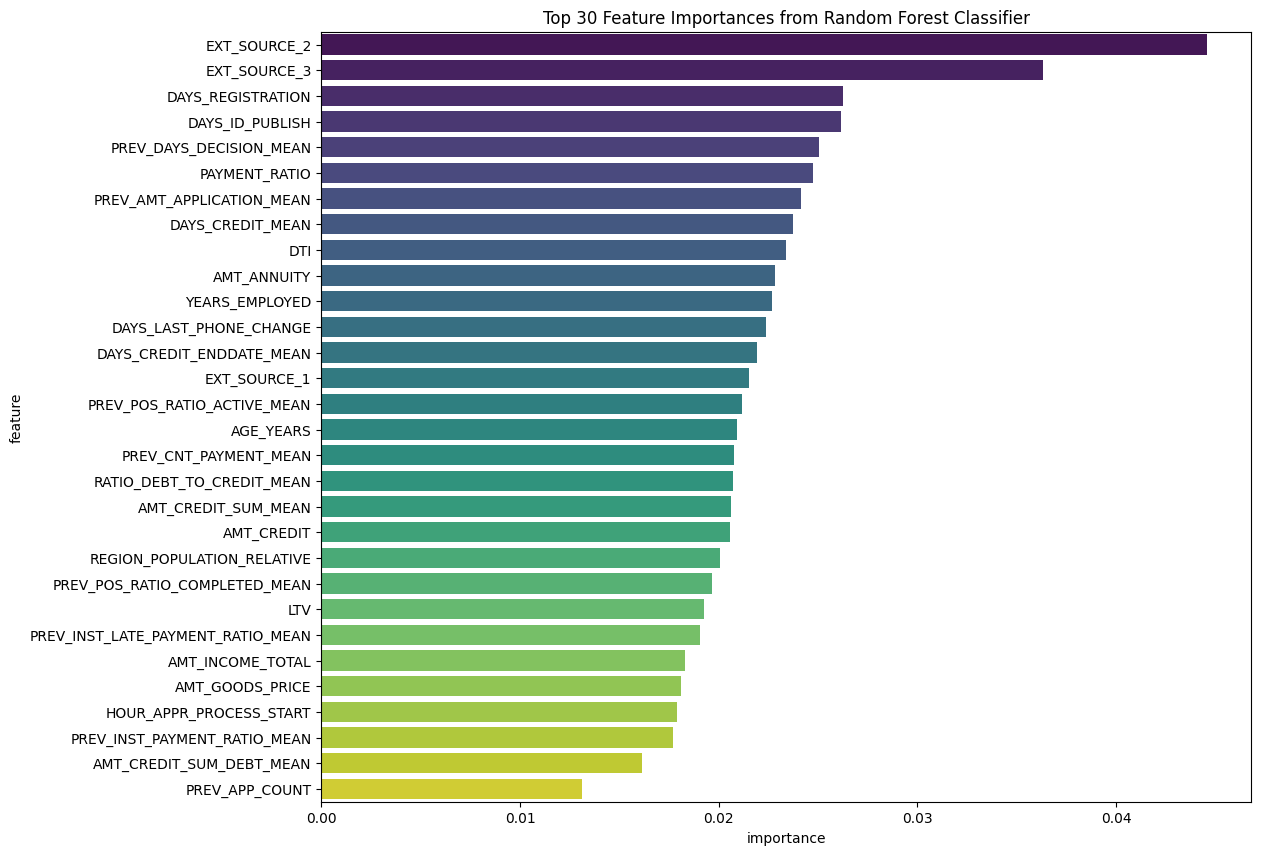

In [52]:
plt.figure(figsize=(12, 10))
sns.barplot(x='importance', y='feature', data=top_30_features, palette='viridis')
plt.title('Top 30 Feature Importances from Random Forest Classifier')
plt.show()

Sinkronisasi antara feature importance & 5C

In [53]:
top_30_stats = top_30_features['feature'].tolist()

features_to_swap = {
    'DAYS_BIRTH': 'AGE_YEARS',
    'DAYS_EMPLOYED': 'YEARS_EMPLOYED',
}

In [54]:
final_stats_features = []
for feature in top_30_stats:
    if feature in features_to_swap:
        replacement = features_to_swap[feature]
        if replacement in df_encoded.columns:
            final_stats_features.append(replacement)
    else:
        final_stats_features.append(feature)

In [55]:
len(final_stats_features)

30

In [56]:
final_stats_features

['EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'PREV_DAYS_DECISION_MEAN',
 'PAYMENT_RATIO',
 'PREV_AMT_APPLICATION_MEAN',
 'DAYS_CREDIT_MEAN',
 'DTI',
 'AMT_ANNUITY',
 'YEARS_EMPLOYED',
 'DAYS_LAST_PHONE_CHANGE',
 'DAYS_CREDIT_ENDDATE_MEAN',
 'EXT_SOURCE_1',
 'PREV_POS_RATIO_ACTIVE_MEAN',
 'AGE_YEARS',
 'PREV_CNT_PAYMENT_MEAN',
 'RATIO_DEBT_TO_CREDIT_MEAN',
 'AMT_CREDIT_SUM_MEAN',
 'AMT_CREDIT',
 'REGION_POPULATION_RELATIVE',
 'PREV_POS_RATIO_COMPLETED_MEAN',
 'LTV',
 'PREV_INST_LATE_PAYMENT_RATIO_MEAN',
 'AMT_INCOME_TOTAL',
 'AMT_GOODS_PRICE',
 'HOUR_APPR_PROCESS_START',
 'PREV_INST_PAYMENT_RATIO_MEAN',
 'AMT_CREDIT_SUM_DEBT_MEAN',
 'PREV_APP_COUNT']

In [57]:
expanded_source = []
for col_5c in select_feature_5c:
    if col_5c in df_encoded.columns:
        expanded_source.append(col_5c)
    
    encoded_cols = [c for c in df_encoded.columns if c.startswith(col_5c + '_')]
    expanded_source.extend(encoded_cols)

In [58]:
len(expanded_source)

47

In [59]:
final_features_set = set(final_stats_features) | set(expanded_source)
final_features_list = list(final_features_set)

final_features_list = [f for f in final_features_list if f in df_encoded.columns]

print(f"Jumlah Fitur Final Gabungan: {len(final_features_list)}")
print("Daftar Fitur Final:")
print(final_features_list)

Jumlah Fitur Final Gabungan: 64
Daftar Fitur Final:
['DAYS_LAST_PHONE_CHANGE', 'OCCUPATION_TYPE_Core staff', 'AMT_CREDIT_SUM_DEBT_MEAN', 'DTI', 'FLAG_OWN_REALTY', 'NAME_HOUSING_TYPE_Rented apartment', 'OCCUPATION_TYPE_Unknown', 'RATIO_DEBT_TO_CREDIT_MEAN', 'OCCUPATION_TYPE_Laborers', 'OCCUPATION_TYPE_HR staff', 'EXT_SOURCE_2', 'DAYS_REGISTRATION', 'OCCUPATION_TYPE_Realty agents', 'OCCUPATION_TYPE_Secretaries', 'EXT_SOURCE_3', 'OCCUPATION_TYPE_Cooking staff', 'LTV', 'HOUR_APPR_PROCESS_START', 'AMT_CREDIT_SUM_MEAN', 'OCCUPATION_TYPE_Drivers', 'OCCUPATION_TYPE_Sales staff', 'REGION_POPULATION_RELATIVE', 'AMT_ANNUITY', 'FLAG_OWN_CAR', 'REGION_RATING_CLIENT', 'OCCUPATION_TYPE_Security staff', 'NAME_FAMILY_STATUS_Widow', 'NAME_HOUSING_TYPE_Office apartment', 'PAYMENT_RATIO', 'AMT_GOODS_PRICE', 'OCCUPATION_TYPE_Private service staff', 'NAME_HOUSING_TYPE_Municipal apartment', 'DAYS_ID_PUBLISH', 'NAME_FAMILY_STATUS_Separated', 'OCCUPATION_TYPE_Low-skill Laborers', 'PREV_INST_LATE_PAYMENT_RATIO_

Proses normalisasi pada seluruh data numerik pada dataset

In [60]:
new_df_modelling_final = df_encoded[final_features_list + ['TARGET']].copy()

In [61]:
X = new_df_modelling_final.drop(columns=['TARGET'], errors='ignore')
y = new_df_modelling_final['TARGET']

cols_to_scale = [col for col in X.columns if X[col].nunique() > 2]
scaler = MinMaxScaler()

X_scaled = X.copy()
X_scaled[cols_to_scale] = scaler.fit_transform(X[cols_to_scale])

print("\nPengecekan Statistik Setelah Normalisasi")
print(X_scaled[cols_to_scale].describe().T[['min', 'max', 'mean', 'std']].head())


Pengecekan Statistik Setelah Normalisasi
                           min  max      mean       std
DAYS_LAST_PHONE_CHANGE     0.0  1.0  0.224338  0.192639
AMT_CREDIT_SUM_DEBT_MEAN   0.0  1.0  0.026846  0.009637
DTI                        0.0  1.0  0.046650  0.031744
RATIO_DEBT_TO_CREDIT_MEAN  0.0  1.0  0.015822  0.002864
EXT_SOURCE_2               0.0  1.0  0.601759  0.223240


### Proses Pemodelan Klasifikasi

In [62]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.25, random_state=42)

#### Pemodelan pada beberapa algoritma tanpa hyperparameter tuning

In [64]:
def running_models(model_for_train, name_model):
    model = model_for_train
    print(f'Training model: {name_model}')
    
    return model.fit(X_train, y_train)

In [65]:
LogReg = running_models(LogisticRegression(max_iter=2000, C=1, random_state=42), 'Logistic Regression')
RF = running_models(RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1), 'Random Forest Classifier')
LightGBM = running_models(lightgbm.LGBMClassifier(n_estimators=50, learning_rate=0.1, random_state=42), 'Light Gradient Boosting Machine')
XGB = running_models(xgb.XGBClassifier(n_estimators=50, learning_rate=0.1, random_state=42, use_label_encoder=False, eval_metric='auc'), 'Extreme Gradient Boosting Machine')

Training model: Logistic Regression
Training model: Random Forest Classifier
Training model: Light Gradient Boosting Machine
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 212024, number of negative: 212005
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029440 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8482
[LightGBM] [Info] Number of data points in the train set: 424029, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500022 -> initscore=0.000090
[LightGBM] [Info] Start training from score 0.000090
Training model: Extreme Gradient Boosting Machine


In [66]:
def evaluate_model_result(models, name_model):
    y_pred = models.predict(X_test)
    name_models = name_model

    print(f"Evaluation Metrics for {name_model}: \n")
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1_scoring = f1_score(y_test, y_pred)

    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-Score: {f1_scoring}\n")

    print(f"Confusion Matrix {name_model}:")
    c_matrix = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(7,5))
    sns.heatmap(c_matrix, annot=True, fmt='d', cmap='viridis')
    plt.title("Confusion Matrix")
    plt.xlabel("Hasil Prediksi")
    plt.ylabel("Nilai Aktual")
    plt.show()

    roc_auc = roc_auc_score(y_test, models.predict_proba(X_test)[:, 1])
    print(f"ROC AUC Score: {roc_auc}\n")

    return accuracy, precision, recall, f1_scoring, c_matrix, roc_auc, name_models

Evaluation Metrics for Logistic Regression: 

Accuracy: 0.6947425765690555
Precision: 0.6922474987423844
Recall: 0.701084033851292
F1-Score: 0.6966377455598836

Confusion Matrix Logistic Regression:


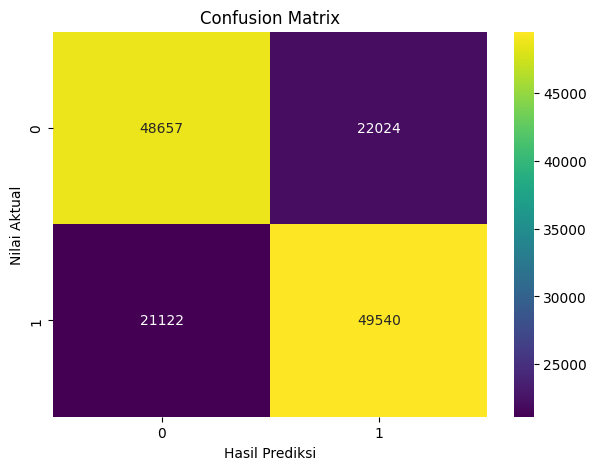

ROC AUC Score: 0.76236257019537



In [67]:
evaluate_logreg = evaluate_model_result(LogReg, 'Logistic Regression')

Evaluation Metrics for Random Forest Classifier: 

Accuracy: 0.9228118831495016
Precision: 0.9267756128221244
Recall: 0.918145537912881
F1-Score: 0.9224403907127522

Confusion Matrix Random Forest Classifier:


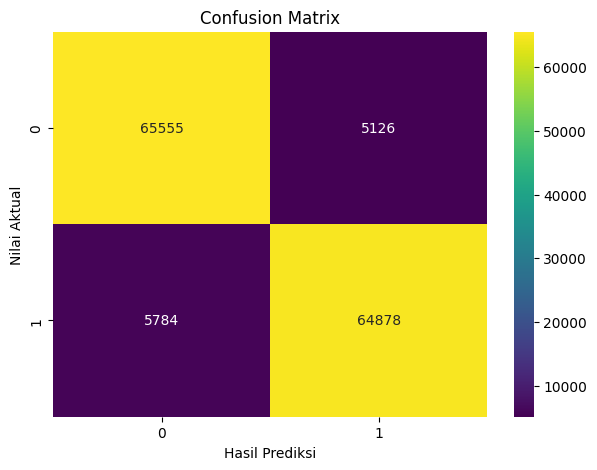

ROC AUC Score: 0.9744862148204874



In [68]:
evaluate_RF = evaluate_model_result(RF, 'Random Forest Classifier')

Evaluation Metrics for Light Gradient Boosting Machine: 

Accuracy: 0.944850470132939
Precision: 0.9910180108408704
Recall: 0.8978234411706434
F1-Score: 0.9421216373747949

Confusion Matrix Light Gradient Boosting Machine:


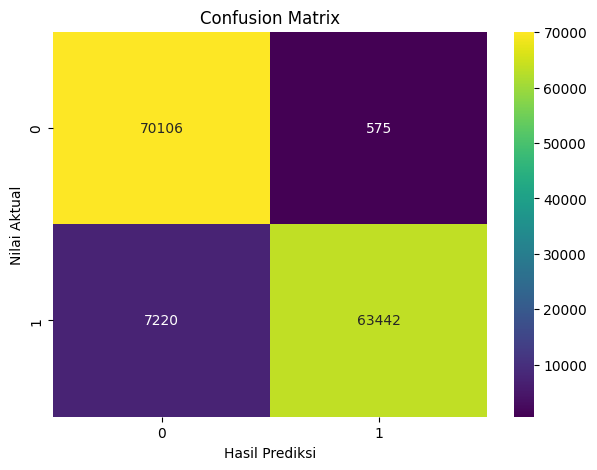

ROC AUC Score: 0.9721673598103558



In [69]:
evaluate_LightGBM = evaluate_model_result(LightGBM, 'Light Gradient Boosting Machine')

Evaluation Metrics for Extreme Gradient Boosting Machine: 

Accuracy: 0.9150647715132691
Precision: 0.9345799931838724
Recall: 0.8925872463275877
F1-Score: 0.9131010720309232

Confusion Matrix Extreme Gradient Boosting Machine:


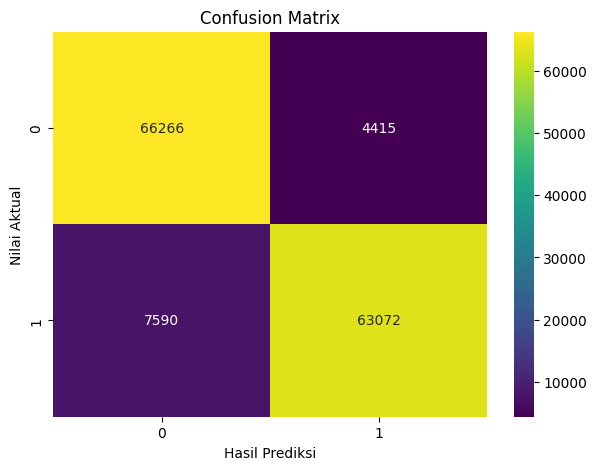

ROC AUC Score: 0.9657112574102799



In [70]:
evaluate_XGB = evaluate_model_result(XGB, 'Extreme Gradient Boosting Machine')

In [71]:
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': RF.feature_importances_
}).sort_values(by='importance', ascending=False)

C:\Users\hardi\AppData\Local\Temp\ipykernel_25420\553812059.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_importance.head(20), palette='viridis')


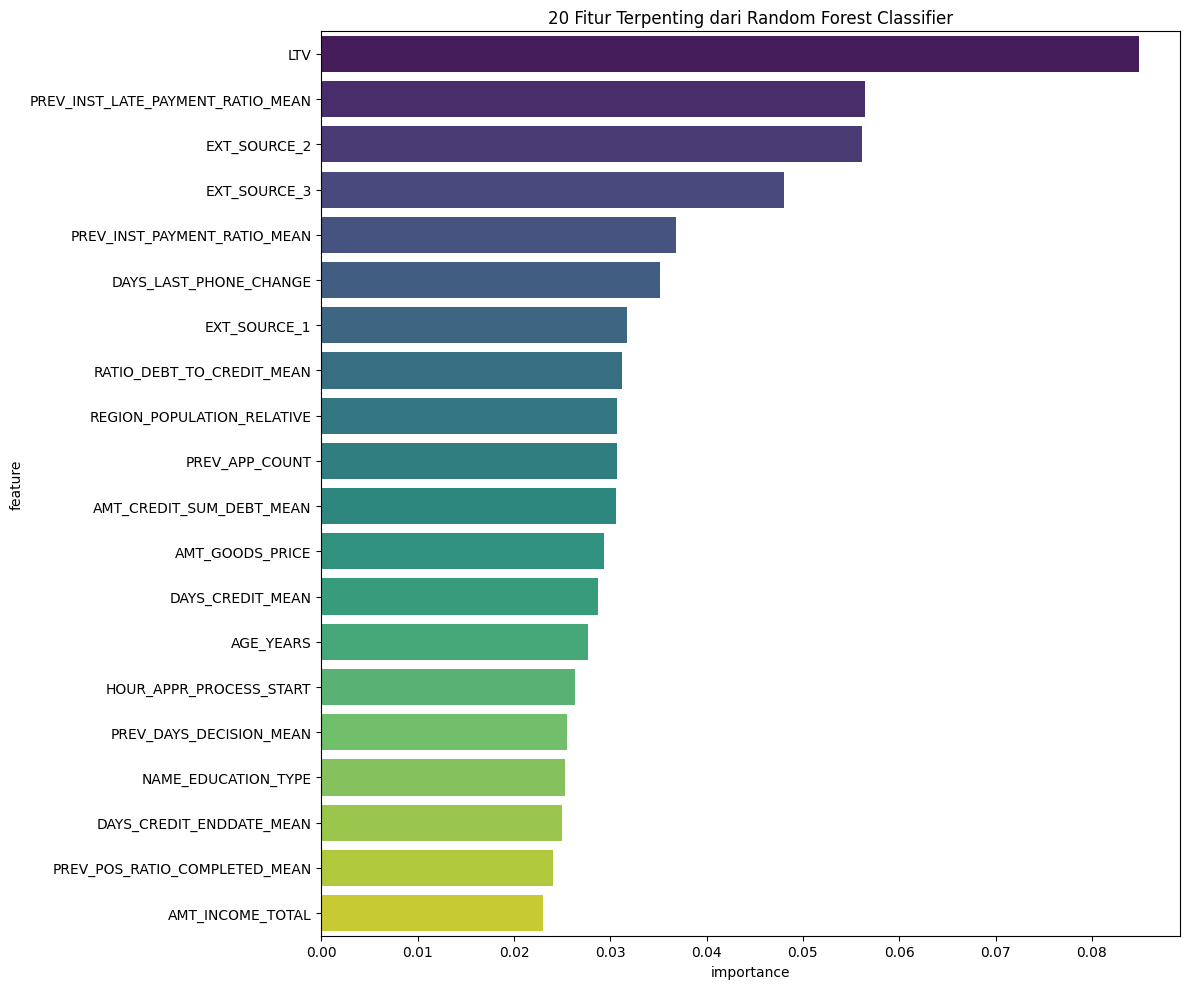

In [72]:
plt.figure(figsize=(12, 10))
sns.barplot(x='importance', y='feature', data=feature_importance.head(20), palette='viridis')
plt.title('20 Fitur Terpenting dari Random Forest Classifier')
plt.tight_layout()
plt.show()

#### Pemodelan dengan menerapkan Hyperparameter Tuning

##### Penerapan pada Random Forest

In [73]:
list_params_RF = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

random_search_RF = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=list_params_RF,
    n_iter=4,
    scoring='roc_auc',
    cv=skf,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

In [74]:
random_search_RF.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


,estimator,RandomForestC...ndom_state=42)
,param_distributions,"{'bootstrap': [True, False], 'max_depth': [None, 10, ...], 'min_samples_leaf': [1, 2, ...], 'min_samples_split': [2, 5, ...], ...}"
,n_iter,4
,scoring,'roc_auc'
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,2
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [75]:
print(f'Best AUC CV: {random_search_RF.best_score_}')
print(f'Best Parameters: {random_search_RF.best_params_}')

best_rf_model = random_search_RF.best_estimator_

Best AUC CV: 0.9588139640224812
Best Parameters: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 20, 'bootstrap': False}


In [76]:
y_pred_proba_RF = best_rf_model.predict_proba(X_test)[:, 1]
auc_test_RF = roc_auc_score(y_test, y_pred_proba_RF)
print(f'ROC-AUC pada data test untuk Random Forest: {auc_test_RF}')

y_pred_RF = (y_pred_proba_RF >= 0.5).astype(int)
print(classification_report(y_test, y_pred_RF))
print(confusion_matrix(y_test, y_pred_RF))

ROC-AUC pada data test untuk Random Forest: 0.9615394125920725
              precision    recall  f1-score   support

           0       0.91      0.89      0.90     70681
           1       0.89      0.91      0.90     70662

    accuracy                           0.90    141343
   macro avg       0.90      0.90      0.90    141343
weighted avg       0.90      0.90      0.90    141343

[[62843  7838]
 [ 6347 64315]]


##### Penerapan pada LightGBM

In [77]:
list_params_LightGBM = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'num_leaves': [31, 50, 100],
    'max_depth': [-1, 10, 20],
    'min_child_samples': [20, 50, 100]
}

random_search_LightGBM = RandomizedSearchCV(
    estimator=lightgbm.LGBMClassifier(random_state=42),
    param_distributions=list_params_LightGBM,
    n_iter=4,
    scoring='roc_auc',
    cv=skf,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

In [78]:
random_search_LightGBM.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 212024, number of negative: 212005
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025305 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8482
[LightGBM] [Info] Number of data points in the train set: 424029, number of used features: 63
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500022 -> initscore=0.000090
[LightGBM] [Info] Start training from score 0.000090


,estimator,LGBMClassifie...ndom_state=42)
,param_distributions,"{'learning_rate': [0.01, 0.1, ...], 'max_depth': [-1, 10, ...], 'min_child_samples': [20, 50, ...], 'n_estimators': [50, 100, ...], ...}"
,n_iter,4
,scoring,'roc_auc'
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,2
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [79]:
print(f'Best AUC CV: {random_search_LightGBM.best_score_}')
print(f'Best Parameters: {random_search_LightGBM.best_params_}')

best_lgbm_model = random_search_LightGBM.best_estimator_

Best AUC CV: 0.9790264702863334
Best Parameters: {'num_leaves': 100, 'n_estimators': 200, 'min_child_samples': 50, 'max_depth': 20, 'learning_rate': 0.1}


In [80]:
y_pred_proba_LGBM = best_lgbm_model.predict_proba(X_test)[:, 1]
auc_test_LGBM = roc_auc_score(y_test, y_pred_proba_LGBM)
print(f'ROC-AUC pada data test untuk LightGBM: {auc_test_LGBM}')

y_pred_LGBM = (y_pred_proba_LGBM >= 0.5).astype(int)
print(classification_report(y_test, y_pred_LGBM))
print(confusion_matrix(y_test, y_pred_LGBM))

ROC-AUC pada data test untuk LightGBM: 0.9793606832301227
              precision    recall  f1-score   support

           0       0.92      0.99      0.96     70681
           1       0.99      0.92      0.95     70662

    accuracy                           0.95    141343
   macro avg       0.96      0.95      0.95    141343
weighted avg       0.96      0.95      0.95    141343

[[70308   373]
 [ 6001 64661]]


#### Summary Hasil Pemodelan

In [81]:
summary_data = [
    {
        "Model": "Logistic Regression (Base)",
        "Accuracy": evaluate_logreg[0],
        "Precision": evaluate_logreg[1],
        "Recall": evaluate_logreg[2],
        "F1-Score": evaluate_logreg[3],
        "ROC-AUC (Test)": evaluate_logreg[5],
        "ROC-AUC (CV)": None,
        "Best Params": None
    },
    {
        "Model": "Random Forest (Base)",
        "Accuracy": evaluate_RF[0],
        "Precision": evaluate_RF[1],
        "Recall": evaluate_RF[2],
        "F1-Score": evaluate_RF[3],
        "ROC-AUC (Test)": evaluate_RF[5],
        "ROC-AUC (CV)": None,
        "Best Params": None
    },
    {
        "Model": "XGBoost (Base)",
        "Accuracy": evaluate_XGB[0],
        "Precision": evaluate_XGB[1],
        "Recall": evaluate_XGB[2],
        "F1-Score": evaluate_XGB[3],
        "ROC-AUC (Test)": evaluate_XGB[5],
        "ROC-AUC (CV)": None,
        "Best Params": None
    },
    {
        "Model": "LightGBM (Base)",
        "Accuracy": evaluate_LightGBM[0],
        "Precision": evaluate_LightGBM[1],
        "Recall": evaluate_LightGBM[2],
        "F1-Score": evaluate_LightGBM[3],
        "ROC-AUC (Test)": evaluate_LightGBM[5],
        "ROC-AUC (CV)": None,
        "Best Params": None
    },
    {
        "Model": "LightGBM (RandomSearch)",
        "Accuracy": accuracy_score(y_test, y_pred_LGBM),
        "Precision": precision_score(y_test, y_pred_LGBM),
        "Recall": recall_score(y_test, y_pred_LGBM),
        "F1-Score": f1_score(y_test, y_pred_LGBM),
        "ROC-AUC (Test)": auc_test_LGBM,
        "ROC-AUC (CV)": random_search_LightGBM.best_score_,
        "Best Params": random_search_LightGBM.best_params_
    },
    {
        "Model": "Random Forest (RandomSearch)",
        "Accuracy": accuracy_score(y_test, y_pred_RF),
        "Precision": precision_score(y_test, y_pred_RF),
        "Recall": recall_score(y_test, y_pred_RF),
        "F1-Score": f1_score(y_test, y_pred_RF),
        "ROC-AUC (Test)": auc_test_RF,
        "ROC-AUC (CV)": random_search_RF.best_score_,
        "Best Params": random_search_RF.best_params_
    }
]

summary_df = pd.DataFrame(summary_data)
display(summary_df)

,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC (Test),ROC-AUC (CV),Best Params
0,Logistic Regression (Base),0.694743,0.692247,0.701084,0.696638,0.762363,NaN,None
1,Random Forest (Base),0.922812,0.926776,0.918146,0.922440,0.974486,NaN,None
2,XGBoost (Base),0.915065,0.934580,0.892587,0.913101,0.965711,NaN,None
3,LightGBM (Base),0.944850,0.991018,0.897823,0.942122,0.972167,NaN,None
4,LightGBM (RandomSearch),0.954904,0.994265,0.915075,0.953027,0.979361,0.979026,"{'num_leaves': 100, 'n_estimators': 200, 'min_..."
5,Random Forest (RandomSearch),0.899641,0.891370,0.910178,0.900676,0.961539,0.958814,"{'n_estimators': 200, 'min_samples_split': 5, ..."


In [82]:
import os, joblib

if not os.path.exists('models'):
    os.makedirs('models')

joblib.dump(best_lgbm_model, 'models/best_lgbm_model.pkl')
joblib.dump(RF, 'models/random_forest_model.pkl')


['models/random_forest_model.pkl']